# M2 Mathématiques Appliquées, Statistique, parcours Data Science.
## Cours Image et Intelligence Articifielle, 
## Enoncé construit par Frédéric Richard, 2021 et complété par Marine Troadec, 2021.
## TP 1.  Gradient stochastique pour la régression multinomiale.


In [1]:
# Import 
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras import models
from matplotlib.gridspec import  GridSpec

Ce TP porte sur la régression multinomiale. L'objectif est d'étudier la descente de gradient stochastique utilisée pour l'estimation des paramètres de ce modèle. On travaillera sur la classification de chiffres manuscrits à partir de la base de données MNIST.


## 1. Données MNIST

La base de données MNIST est une base de données de chiffres écrits à la main. 

![MNIST](tp1-figure0.png "MNIST")
 
Il s'agit d'une base de référence qui sert notamment à tester et comparer des algorithmes d'apprentissage statistique. L'objectif est de déterminer le chiffre écrit sur chaque image (problème de classification d'images). La base MNIST se compose 60000 images d'apprentissage et 10000 de test. En Python, elle se télécharge facilement avec le package keras:

In [2]:
from keras.datasets import mnist
(X0, Y0), (X1, Y1) = mnist.load_data()

Dans cette importation, X0 et X1 sont des bases d'images d'apprentissage et de test, respectivement. Ce sont des numpy.ndarray de taille n x 28 x 28, où n=60000 pour X0 et n=10000 pour X1. X0(i, :, :) est la ième image de la base d'apprentissage ; elle est de taille 28x28. On peut l'afficher avec la fonction imshow de matplotlib.pyplot. Les variables Y0 et Y1 contiennent les classes des observations dans chacune des bases. Les classes sont étiquetées de 0 à 9. 


Avant toute analyse, on préparer les données de la manière suivante:

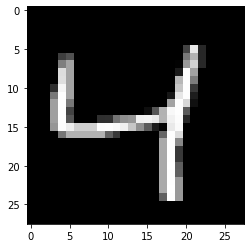

In [3]:
from matplotlib import pyplot as plt

# On met le type des images en float.
X0 = X0.astype('float32')
X1 = X1.astype('float32')
# On met les images sous la forme de vecteur.
X0 = X0.reshape(60000, 784)
X1 = X1.reshape(10000, 784) 
# On normalise les images.
X0 /= 255
X1 /= 255
n = 2
plt.imshow(X0[n, :].reshape(28, 28), cmap="gray")

## 2. Régression multinomiale.

La régression multinomiale est un modèle de classification qui étend la régression logistique lorsque le nombre de classes possibles est supérieur à 2. Le modèle est le suivant. On décrit la classe d'un individu au moyen d'une variable aléatoire $Y$ à valeurs dans un ensemble discret $\{1,\cdots, K\}$ représentant des étiquettes de classe. Pour chaque individu, on dispose de variables $x$ (dites de régression) dans $\mathbb{R}^p$. On suppose que la distribution de probabilités de $Y$ dépend de $x$ et d'un ensemble $\theta = (\theta^{(k)})_{k=1}^K$ de $K$ vecteurs de paramètres inconnus $\theta^{(k)}$ dans $\mathbb{R}^{p+1}$ selon le modèle **"soft-max"**
\begin{equation} \label{eqn:softmax_proba}
  \forall \: k \in \{1,\cdots, K\}, \: \mathbb{P}(Y = k) = \frac{\exp(\langle \theta^{(k)}, \:  \tilde{x} \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x} \rangle )},\:\:\mathrm{avec}\:\: \tilde{x} =  \left( \begin{array}{c} 1 \\ x \end{array} \right). \end{equation}

Les estimateurs du maximum de vraisemblance de l'échantillon sont les paramètres $\theta$ qui minimisent le **critère d'entropie croisée**:
    \begin{equation} \label{eqn:entropiecroisee}
       \mathcal{S}(\theta) = - \frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K z_i^{(k)} \log\left(p_i^{(k)}(\theta) \right),\end{equation}
    avec
    \begin{equation} 
    z_i^{(k)} =  \mathbf{1}_{y_i = k}\:\:\:\mathrm{et}\:\:\: p_i^{(k)}(\theta) = \frac{\exp(\langle \theta^{(k)},  \: \tilde{x}_i \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x}_i \rangle )}. 
    \end{equation}   

 

Dans le cadre de ce TP, l'objectif est de classer les images MNIST en K=10 classes $\{0, \cdots, 9\}$. La variable $x_i$ représente la ième image (sous forme vectorielle) de la base d'apprentissage et $y_i$ son étiquette de classe.


## 3. Descente de gradient.

Une descente de gradient est un algorithme itératif permettant de minimiser une application différentiable $\mathcal{S}$ par rapport à un ensemble de variables $\theta$. Dans la descente de gradient à pas fixe, la mise à jour des variables $\theta$ s'écrit à chaque itération
\begin{equation} \label{eqn:miseajour}
  \theta \longleftarrow \theta - \rho \: \nabla_{\theta}  \mathcal{S}(\theta),
  \end{equation}
o\`u $\rho>0$ désigne un pas fixe et $\nabla_{\theta} \mathcal{S}$ le gradient de $\mathcal{S}$ par rapport à $\theta$. 


\exo  Le gradient de l'entropie croisée $\mathcal{S}$ par rapport à $\theta^{(k)}$ en $\theta$ vaut
    $$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i . $$


**Exercice 1.** Écrire une fonction Python qui calcule ce gradient en respectant le modèle suivant.

In [4]:
def Soft_Max(X, Theta):
    """
    Modèle soft-max de distribution de probabilité.        

    Parameters
    ----------
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.

    Returns
    -------
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités
        des classes de toutes les observations.
        Sur la ligne i et la colonne k, P[i, k] donne l'estimation de 
        la probabilité que la ième observation soit dans la classe k
        selon le modèle soft-max.
    """   
    # Transformations linéaires et exponentielles.
    P = np.exp(np.dot(X, Theta[1:, :]) + Theta[0, :])
    # Normalisation.
    P = P / np.sum(P, axis=1).reshape(P.shape[0], 1)

    return(P)

def Cross_Entropy(C, P):
    """
    Critère d'entropie croisée.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
   
    Returns
    -------
    J : scalar.
        Valeur de l'entropie croisée.
    """ 
    V = np.zeros(C.shape)
    for i in range(V.shape[0]):
        V[i] = np.log(P[i, C[i]])
    
    return(-np.mean(V, axis=None))

In [5]:
def Gradient(C,P,X, Theta):
    """
    Gradient de l'entropie croisée 
    
    Paramètres 
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.
    
    Returns
    -------
    G : ndarray (p+1 x K). 
    """
    X = np.c_[np.ones(X.shape[0]),X]  #Ajoute le vecteur 1 à la matrice de desing 
    n = X.shape[0] 
    G = np.zeros(Theta.shape)  #Matrice contenant après les gradients des différents paramètres 
    
    for k in range(P.shape[1]) :  #Pour chaque paramètre associé à une classe    
        z = [0 if np.where(P[i] == P[i,:].max())[0][0] != C[i] and C[i] != k else 1 for i in range(n)]  #Vecteur indicateur 
        G[:,k] = np.sum(1/n*(X.T*(P[:,k]-z)), axis=1)  #Gradient de tous les paramètres de cette classe 
    return G 

In [6]:
# Variation du code pour tester l'efficacité. N'est pas plus rapide et meme plus long que l'autre version.

#def Gradient(C,P,X, Theta):
   
#    X = np.c_[np.ones(X.shape[0]),X]  #Ajoute le vecteur 1 à la matrice de desing 
#    n = X.shape[0] 
#    G = np.zeros(Theta.shape)  #Matrice contenant après les gradients des différents paramètres 
#    z = np.array([[0 if np.where(P[i] == P[i,:].max())[0][0] != C[i] and C[i] != k else 1 for i in range(n)] for k in range(P.shape[1])])
    
#    for k in range(P.shape[1]) : 
        
#        G[:,k] = np.sum(1/n*(X.T*(P[:,k]-z[k,:].T)), axis = 1) 
    
#    return G 

**Exercice 2.** Appliquer l'algorithme de descente de gradient sur les données MNIST en prenant 50000 données d'apprentissage et 10000 de validation. A chaque époque (itération), calculer la valeur de l'entropie sur les données d'apprentissage et de validations, ainsi que les scores de classification sur ces deux jeux de données. Relever également le temps d'exécution de chaque époque. Tracer ensuite les valeurs d'entropie et les scores de classification en fonction du temps de calcul (et/ou de l'époque). Pour le calcul du score de classification, on pourra s'aider de la fonction suivante.

In [7]:
def Classification_Score(C, X, Theta):
    """
    Score de classification obtenu par régression multinomiale.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    P = Soft_Max(X, Theta)
    Cest = np.argmax(P, axis=1)
    score = np.nonzero(Cest == C)[0].size / P.shape[0] * 100
    
    return(score, P)

In [8]:
#Création de données de validation 

X_train = X0[:50000]
X_test = X0[50000:]

y_train = Y0[:50000]
y_test = Y0[50000:]

#Jeu de données train et test

#X_train = X0
#X_test = X1

#y_train = Y0
#y_test = Y1

iteration = 800

In [9]:
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)

In [10]:
def DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration, rho=1e-2) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = [] #liste qui contiendra le loss
    score_train = []  
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    for i in range(iteration) : 
        
        start_time = time.time()
        
        P_train =  Soft_Max(X_train, Theta)  #Proba de chaque classe pour le train 
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))  #Erreur train
        Entropie_Test.append(Cross_Entropy(y_test, P_test))  #Erreur test 
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])  #Score train 
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])  #Score test
    
        G = Gradient(y_train,P_train,X_train, Theta)
        
        Theta -= rho*G  #Mise à jour du gradient 
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
    return(Entropie_Train,Entropie_Test,score_train,score_test, Theta)
        
        

In [11]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)

--- 8.547925233840942 seconds ---
--- 7.669341087341309 seconds ---
--- 7.2555930614471436 seconds ---
--- 7.062327861785889 seconds ---
--- 7.0554139614105225 seconds ---
--- 6.87836217880249 seconds ---
--- 7.081050872802734 seconds ---
--- 7.0229902267456055 seconds ---
--- 7.022436857223511 seconds ---
--- 7.27484130859375 seconds ---
--- 7.078172922134399 seconds ---
--- 6.955261945724487 seconds ---
--- 7.287977933883667 seconds ---
--- 6.997620105743408 seconds ---
--- 7.070071697235107 seconds ---
--- 7.10516095161438 seconds ---
--- 7.347136735916138 seconds ---
--- 7.232448101043701 seconds ---
--- 6.980289936065674 seconds ---
--- 7.106909990310669 seconds ---
--- 7.07307505607605 seconds ---
--- 6.970324993133545 seconds ---
--- 6.882244825363159 seconds ---
--- 6.904911279678345 seconds ---
--- 6.988369941711426 seconds ---
--- 7.093645095825195 seconds ---
--- 7.108446836471558 seconds ---
--- 7.188477277755737 seconds ---
--- 7.215598821640015 seconds ---
--- 7.000052928

--- 6.9384541511535645 seconds ---
--- 6.6952900886535645 seconds ---
--- 6.739140272140503 seconds ---
--- 7.037928342819214 seconds ---
--- 6.979879140853882 seconds ---
--- 6.7288126945495605 seconds ---
--- 6.810657024383545 seconds ---
--- 6.83725380897522 seconds ---
--- 6.662894010543823 seconds ---
--- 6.769444942474365 seconds ---
--- 6.6799280643463135 seconds ---
--- 6.641329765319824 seconds ---
--- 6.8126890659332275 seconds ---
--- 6.659446954727173 seconds ---
--- 6.745973825454712 seconds ---
--- 6.749825954437256 seconds ---
--- 6.642452239990234 seconds ---
--- 6.876014232635498 seconds ---
--- 6.769047260284424 seconds ---
--- 6.794871091842651 seconds ---
--- 6.742265939712524 seconds ---
--- 6.729028701782227 seconds ---
--- 6.631083965301514 seconds ---
--- 6.889819145202637 seconds ---
--- 6.752618074417114 seconds ---
--- 6.791347980499268 seconds ---
--- 6.723487854003906 seconds ---
--- 6.644460201263428 seconds ---
--- 6.759817838668823 seconds ---
--- 6.7908

--- 6.606090068817139 seconds ---
--- 6.478854179382324 seconds ---
--- 6.526533126831055 seconds ---
--- 6.546074867248535 seconds ---
--- 6.804524898529053 seconds ---
--- 6.588519096374512 seconds ---
--- 6.788387060165405 seconds ---
--- 6.575629234313965 seconds ---
--- 6.885411262512207 seconds ---
--- 6.741624116897583 seconds ---
--- 6.6819939613342285 seconds ---
--- 6.7005369663238525 seconds ---
--- 6.605881929397583 seconds ---
--- 6.543484210968018 seconds ---
--- 6.683021068572998 seconds ---
--- 6.648533821105957 seconds ---
--- 6.643336057662964 seconds ---
--- 6.673606872558594 seconds ---
--- 6.652873277664185 seconds ---
--- 6.989339113235474 seconds ---
--- 6.822083950042725 seconds ---
--- 6.686125993728638 seconds ---
--- 6.529560804367065 seconds ---
--- 6.56333589553833 seconds ---
--- 6.591619968414307 seconds ---
--- 6.610227823257446 seconds ---
--- 6.612202882766724 seconds ---
--- 6.768752098083496 seconds ---
--- 6.6025660037994385 seconds ---
--- 6.520097

--- 6.462255001068115 seconds ---
--- 6.4727349281311035 seconds ---
--- 6.641701936721802 seconds ---
--- 6.581083059310913 seconds ---
--- 6.484138011932373 seconds ---
--- 6.592198133468628 seconds ---
--- 6.536373853683472 seconds ---
--- 6.470637083053589 seconds ---
--- 6.563977003097534 seconds ---
--- 6.531864166259766 seconds ---
--- 6.550401926040649 seconds ---
--- 6.506808042526245 seconds ---
--- 6.477940320968628 seconds ---
--- 6.529455900192261 seconds ---
--- 6.557391166687012 seconds ---
--- 6.528785943984985 seconds ---
--- 6.516239166259766 seconds ---
--- 6.6570820808410645 seconds ---
--- 6.556211948394775 seconds ---
--- 6.511502027511597 seconds ---
--- 6.76816987991333 seconds ---
--- 6.489477157592773 seconds ---
--- 6.5502331256866455 seconds ---
--- 6.437557220458984 seconds ---
--- 6.498573064804077 seconds ---
--- 6.512624025344849 seconds ---
--- 6.639758825302124 seconds ---
--- 6.380377769470215 seconds ---
--- 6.492071151733398 seconds ---
--- 6.476535

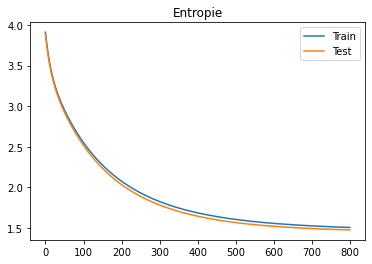

In [12]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

Les deux courbes décroissent à la même vitesse, ce qui est un marqueur d'un bon fonctionnement de l'agorithme. En effet, nous observons ni over ou under fitting. 

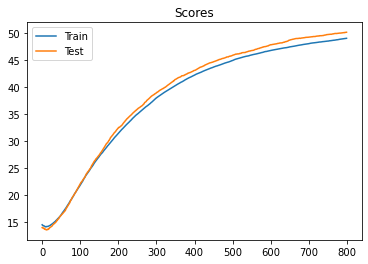

In [13]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Les scores plafonent à 50, ce qui n'est pas incoryable .. La régression logistique appliquée comme ici ne prend pas en compte l'emplacement des informations de l'image. Cette dernière est traité comme un ensemble lisse de données, or l'emplacement des informaitons est importante ! Nous pourions regarder plus précisément ce que notre modèle prédit pour essayer de comprendre ce qui est appris.

---

**Fonction de prédition**

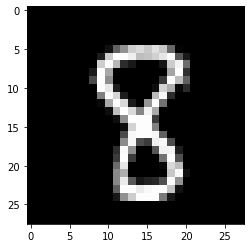

In [14]:
plt.imshow(X_test[1, :].reshape(28, 28), cmap="gray")

In [15]:
def prediction(X, Theta) : 
    P = Soft_Max(X, Theta)
    #print(P[0])
    pred = []
    for i in P : 
        pred.append(np.argmax(i))
    return pred

In [16]:
y_pred = prediction(X_test, Theta_DG)

In [17]:
y_pred[1]

0

## 4. Descente de gradient stochastique par mini-lots.

L'algorithme de gradient stochastique est une modification de l'algorithme du gradient qui consiste à prendre un seul exemple d'apprentissage au hasard pour mettre à jour le paramètre $\theta$ à chaque époque. On s'intéresse ici à une variante de l'algorithme de gradient stochastique qui fait ces mises à jour en prenant une série de mini-lots (batchs) d'exemples d'apprentissage tiré au hasard. Pour cet algorithme, le gradient de l'entropie croisée $\mathcal{S}$ s'écrira
$$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{m} \sum_{i \in B_j} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i, $$
o\`u $B_j$ est un ensemble qui regroupe $m$ indices d'un jème lot d'observations pris au hasard. Une époque de l'algorithme consistera en une série de plusieurs mises à jour faisant intervenir différents lots. Le nombre de mises à jour pour une époque pourra par exemple être fixé à $\lfloor n / m \rfloor$. La descente de gradient ordinaire est un cas particulier de la descente de gradient stochastique lorsque l'on fixe $m=n$. 

**Exercice 3.** Modifier le programme de la section précédente pour inclure des mises à jour sur mini-lots. Appliquer le programme aux données MNIST. Comparer les convergences des algorithmes de gradient et gradient stochastique par mini-lots. Discuter.



In [18]:
def DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=1,rho=1e-2) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 
    batch : réel 
        Nombre de mini-lots

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = []
    score_train = []
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    pas = X_train.shape[0] // batch  #Division en mini lot 
    
    for i in range(iteration) :  #Pour chaque itération 
        
        ind = 0
        
        for b in range(batch) :  #Pour chaque mini-lot 
        
            start_time = time.time()

            P_train =  Soft_Max(X_train[ind:ind+pas], Theta)          

            G = Gradient(y_train[ind:ind+pas],P_train,X_train[ind:ind+pas], Theta)

            Theta -= rho*G
            
            ind += pas 
            
            print("--- %s seconds ---" % (time.time() - start_time))
            
        P_train =  Soft_Max(X_train, Theta)
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))
        Entropie_Test.append(Cross_Entropy(y_test, P_test))
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])
        
    return(Entropie_Train,Entropie_Test,score_train,score_test)

In [19]:
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)
iteration = 100 #Plus bas car trop long pour cette version du code 

In [20]:
(Entropie_Train,Entropie_Test,score_train,score_test) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.5412578582763672 seconds ---
--- 0.5612468719482422 seconds ---
--- 0.5642459392547607 seconds ---
--- 0.534987211227417 seconds ---
--- 0.5732378959655762 seconds ---
--- 0.549177885055542 seconds ---
--- 0.5697512626647949 seconds ---
--- 0.5662961006164551 seconds ---
--- 0.5691609382629395 seconds ---
--- 0.564892053604126 seconds ---
--- 0.5621440410614014 seconds ---
--- 0.5639019012451172 seconds ---
--- 0.566551923751831 seconds ---
--- 0.5360052585601807 seconds ---
--- 0.5791909694671631 seconds ---
--- 0.5889577865600586 seconds ---
--- 0.5771219730377197 seconds ---
--- 0.5563819408416748 seconds ---
--- 0.5505659580230713 seconds ---
--- 0.5467100143432617 seconds ---
--- 0.5372211933135986 seconds ---
--- 0.5660760402679443 seconds ---
--- 0.609483003616333 seconds ---
--- 0.5489721298217773 seconds ---
--- 0.5605130195617676 seconds ---
--- 0.5485939979553223 seconds ---
--- 0.5582261085510254 seconds ---
--- 0.5491483211517334 seconds ---
--- 0.5421051979064941 se

--- 0.543283224105835 seconds ---
--- 0.5376138687133789 seconds ---
--- 0.5337557792663574 seconds ---
--- 0.5246222019195557 seconds ---
--- 0.505047082901001 seconds ---
--- 0.5226569175720215 seconds ---
--- 0.530937910079956 seconds ---
--- 0.5425820350646973 seconds ---
--- 0.5356919765472412 seconds ---
--- 0.5456030368804932 seconds ---
--- 0.5355000495910645 seconds ---
--- 0.5312929153442383 seconds ---
--- 0.5304429531097412 seconds ---
--- 0.5324130058288574 seconds ---
--- 0.5010039806365967 seconds ---
--- 0.5224592685699463 seconds ---
--- 0.5292038917541504 seconds ---
--- 0.5388779640197754 seconds ---
--- 0.5223379135131836 seconds ---
--- 0.5470447540283203 seconds ---
--- 0.5278840065002441 seconds ---
--- 0.5365550518035889 seconds ---
--- 0.5708043575286865 seconds ---
--- 0.5216362476348877 seconds ---
--- 0.5037031173706055 seconds ---
--- 0.5247938632965088 seconds ---
--- 0.5339069366455078 seconds ---
--- 0.5362789630889893 seconds ---
--- 0.5356349945068359 

--- 0.5211880207061768 seconds ---
--- 0.511760950088501 seconds ---
--- 0.5132169723510742 seconds ---
--- 0.5210559368133545 seconds ---
--- 0.5246767997741699 seconds ---
--- 0.5181469917297363 seconds ---
--- 0.5636990070343018 seconds ---
--- 0.5124521255493164 seconds ---
--- 0.5388939380645752 seconds ---
--- 0.4907262325286865 seconds ---
--- 0.5240139961242676 seconds ---
--- 0.5020270347595215 seconds ---
--- 0.5249161720275879 seconds ---
--- 0.5195560455322266 seconds ---
--- 0.518326997756958 seconds ---
--- 0.5169181823730469 seconds ---
--- 0.521881103515625 seconds ---
--- 0.548551082611084 seconds ---
--- 0.5169222354888916 seconds ---
--- 0.5204441547393799 seconds ---
--- 0.5195870399475098 seconds ---
--- 0.5835111141204834 seconds ---
--- 0.5193221569061279 seconds ---
--- 0.5202858448028564 seconds ---
--- 0.5274350643157959 seconds ---
--- 0.5280539989471436 seconds ---
--- 0.5134420394897461 seconds ---
--- 0.5174479484558105 seconds ---
--- 0.5131640434265137 s

--- 0.5153999328613281 seconds ---
--- 0.506598949432373 seconds ---
--- 0.5111620426177979 seconds ---
--- 0.5461938381195068 seconds ---
--- 0.48525500297546387 seconds ---
--- 0.5258519649505615 seconds ---
--- 0.5798099040985107 seconds ---
--- 0.5229499340057373 seconds ---
--- 0.508002758026123 seconds ---
--- 0.527033805847168 seconds ---
--- 0.523845911026001 seconds ---
--- 0.5380549430847168 seconds ---
--- 0.5258450508117676 seconds ---
--- 0.5252392292022705 seconds ---
--- 0.4886929988861084 seconds ---
--- 0.5177831649780273 seconds ---
--- 0.5049409866333008 seconds ---
--- 0.5072779655456543 seconds ---
--- 0.5142159461975098 seconds ---
--- 0.512516975402832 seconds ---
--- 0.5423369407653809 seconds ---
--- 0.5137989521026611 seconds ---
--- 0.5373251438140869 seconds ---
--- 0.5240607261657715 seconds ---
--- 0.4874758720397949 seconds ---
--- 0.5254778861999512 seconds ---
--- 0.5278029441833496 seconds ---
--- 0.5238268375396729 seconds ---
--- 0.5112099647521973 s

--- 0.5210349559783936 seconds ---
--- 0.5032360553741455 seconds ---
--- 0.5025429725646973 seconds ---
--- 0.5046970844268799 seconds ---
--- 0.516671895980835 seconds ---
--- 0.5489897727966309 seconds ---
--- 0.5018963813781738 seconds ---
--- 0.5012340545654297 seconds ---
--- 0.5074429512023926 seconds ---
--- 0.4785909652709961 seconds ---
--- 0.5123131275177002 seconds ---
--- 0.5100469589233398 seconds ---
--- 0.5250668525695801 seconds ---
--- 0.5299661159515381 seconds ---
--- 0.5185730457305908 seconds ---
--- 0.5262143611907959 seconds ---
--- 0.5174939632415771 seconds ---
--- 0.5332348346710205 seconds ---
--- 0.5098278522491455 seconds ---
--- 0.4888770580291748 seconds ---
--- 0.5587680339813232 seconds ---
--- 0.522601842880249 seconds ---
--- 0.5218040943145752 seconds ---
--- 0.5079629421234131 seconds ---
--- 0.5052940845489502 seconds ---
--- 0.5209519863128662 seconds ---
--- 0.5211970806121826 seconds ---
--- 0.5122427940368652 seconds ---
--- 0.5178351402282715

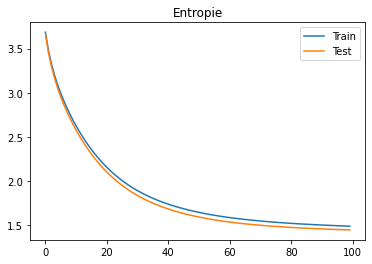

In [21]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

Ce graphique nous montre ni under ni over fitting. 

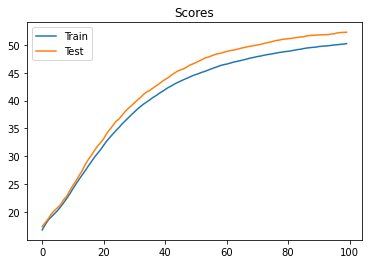

In [22]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Le score atteint 50% de réussite avec 8 fois d'itérations de moins que de données que le gradient non stochastique. Nous pouvons aussi voir un début de gap entre le test et le train dont il faut être attentif car il peut souligner le début d'overfitting.

---

**Exercice 4.** On réduit le nombre d'exemples d'apprentissage à 1000. Comparer et discuter les convergences des algorithmes appliqués dans ce cas et dans celui o\`u le nombre d'exemple est fixé à 50000.



In [23]:
X_train = X0[:1000]
y_train = Y0[:1000]

In [24]:
#random.seed(10)
#Theta = np.random.rand(X_train.shape[1]+1, 10)

In [25]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)
(Entropie_Train_St,Entropie_Test_St,score_train_St,score_test_St) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.1933279037475586 seconds ---
--- 0.16705083847045898 seconds ---
--- 0.17130303382873535 seconds ---
--- 0.16676592826843262 seconds ---
--- 0.17155885696411133 seconds ---
--- 0.16752910614013672 seconds ---
--- 0.17006683349609375 seconds ---
--- 0.16629815101623535 seconds ---
--- 0.17022991180419922 seconds ---
--- 0.1668379306793213 seconds ---
--- 0.17172670364379883 seconds ---
--- 0.16679883003234863 seconds ---
--- 0.16973066329956055 seconds ---
--- 0.16539788246154785 seconds ---
--- 0.17283391952514648 seconds ---
--- 0.1671309471130371 seconds ---
--- 0.17205405235290527 seconds ---
--- 0.16529202461242676 seconds ---
--- 0.16869282722473145 seconds ---
--- 0.16626501083374023 seconds ---
--- 0.16992998123168945 seconds ---
--- 0.16553902626037598 seconds ---
--- 0.1704108715057373 seconds ---
--- 0.16728496551513672 seconds ---
--- 0.17217421531677246 seconds ---
--- 0.1644449234008789 seconds ---
--- 0.16712093353271484 seconds ---
--- 0.16543269157409668 seconds -

--- 0.010860919952392578 seconds ---
--- 0.013059139251708984 seconds ---
--- 0.011226892471313477 seconds ---
--- 0.009917974472045898 seconds ---
--- 0.009849071502685547 seconds ---
--- 0.009945154190063477 seconds ---
--- 0.009385108947753906 seconds ---
--- 0.009840011596679688 seconds ---
--- 0.009484052658081055 seconds ---
--- 0.009351730346679688 seconds ---
--- 0.009593963623046875 seconds ---
--- 0.010079145431518555 seconds ---
--- 0.009680747985839844 seconds ---
--- 0.009536027908325195 seconds ---
--- 0.01105809211730957 seconds ---
--- 0.010626077651977539 seconds ---
--- 0.009415149688720703 seconds ---
--- 0.009668111801147461 seconds ---
--- 0.009498834609985352 seconds ---
--- 0.009392023086547852 seconds ---
--- 0.009629011154174805 seconds ---
--- 0.009750127792358398 seconds ---
--- 0.009633064270019531 seconds ---
--- 0.00958395004272461 seconds ---
--- 0.009535789489746094 seconds ---
--- 0.009618043899536133 seconds ---
--- 0.009370088577270508 seconds ---
---

--- 0.010312795639038086 seconds ---
--- 0.012800931930541992 seconds ---
--- 0.009263038635253906 seconds ---
--- 0.011271953582763672 seconds ---
--- 0.012639045715332031 seconds ---
--- 0.009390115737915039 seconds ---
--- 0.009751081466674805 seconds ---
--- 0.009504079818725586 seconds ---
--- 0.010869979858398438 seconds ---
--- 0.009547948837280273 seconds ---
--- 0.009479045867919922 seconds ---
--- 0.009680032730102539 seconds ---
--- 0.009256839752197266 seconds ---
--- 0.009825944900512695 seconds ---
--- 0.009294748306274414 seconds ---
--- 0.009383916854858398 seconds ---
--- 0.009608983993530273 seconds ---
--- 0.00961613655090332 seconds ---
--- 0.009703874588012695 seconds ---
--- 0.009330987930297852 seconds ---
--- 0.00949716567993164 seconds ---
--- 0.009533882141113281 seconds ---
--- 0.009189128875732422 seconds ---
--- 0.009584188461303711 seconds ---
--- 0.009428977966308594 seconds ---
--- 0.009690046310424805 seconds ---
--- 0.011940240859985352 seconds ---
---

--- 0.011513233184814453 seconds ---
--- 0.012784719467163086 seconds ---
--- 0.010899066925048828 seconds ---
--- 0.009484052658081055 seconds ---
--- 0.009443044662475586 seconds ---
--- 0.009887933731079102 seconds ---
--- 0.009089946746826172 seconds ---
--- 0.009631156921386719 seconds ---
--- 0.009227991104125977 seconds ---
--- 0.009354114532470703 seconds ---
--- 0.00944209098815918 seconds ---
--- 0.009576797485351562 seconds ---
--- 0.009637117385864258 seconds ---
--- 0.009731769561767578 seconds ---
--- 0.012730121612548828 seconds ---
--- 0.011136770248413086 seconds ---
--- 0.00940084457397461 seconds ---
--- 0.00972604751586914 seconds ---
--- 0.009356975555419922 seconds ---
--- 0.009276866912841797 seconds ---
--- 0.009398937225341797 seconds ---
--- 0.009579896926879883 seconds ---
--- 0.009771108627319336 seconds ---
--- 0.009536027908325195 seconds ---
--- 0.009449005126953125 seconds ---
--- 0.009335994720458984 seconds ---
--- 0.009212017059326172 seconds ---
--- 

--- 0.009156227111816406 seconds ---
--- 0.009570598602294922 seconds ---
--- 0.009119033813476562 seconds ---
--- 0.009237051010131836 seconds ---
--- 0.009351968765258789 seconds ---
--- 0.009389162063598633 seconds ---
--- 0.010876893997192383 seconds ---
--- 0.009287118911743164 seconds ---
--- 0.009448051452636719 seconds ---
--- 0.009442806243896484 seconds ---
--- 0.009015083312988281 seconds ---
--- 0.009292840957641602 seconds ---
--- 0.009150981903076172 seconds ---
--- 0.009252071380615234 seconds ---
--- 0.010057926177978516 seconds ---
--- 0.011432886123657227 seconds ---
--- 0.009961128234863281 seconds ---
--- 0.010534048080444336 seconds ---
--- 0.009751081466674805 seconds ---
--- 0.00942683219909668 seconds ---
--- 0.009516000747680664 seconds ---
--- 0.009462118148803711 seconds ---
--- 0.009248971939086914 seconds ---
--- 0.00934600830078125 seconds ---
--- 0.009452104568481445 seconds ---
--- 0.009364843368530273 seconds ---
--- 0.009433984756469727 seconds ---
---

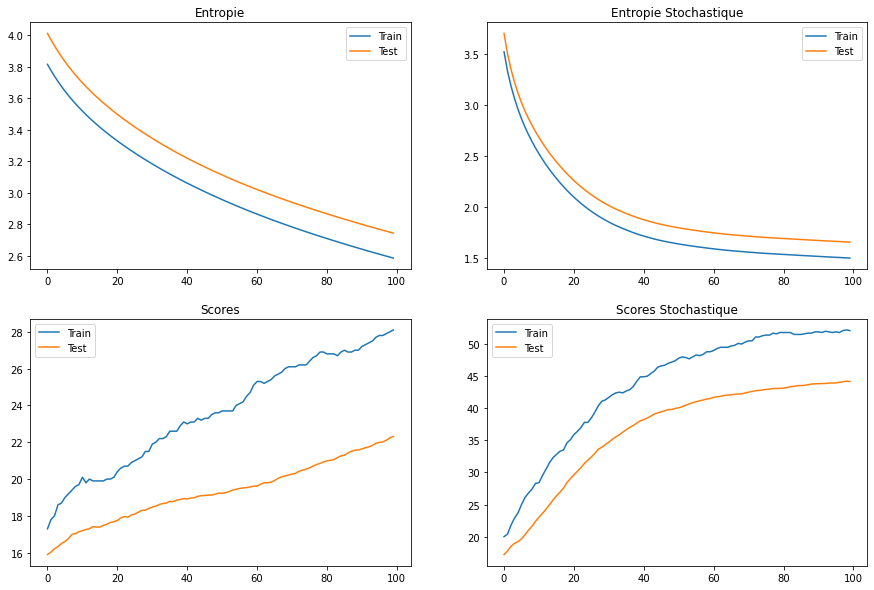

In [26]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.subplot(222)

y = np.array(Entropie_Train_St)
w = np.array(Entropie_Test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie Stochastique")

plt.subplot(223)

y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.subplot(224)

y = np.array(score_train_St)
w = np.array(score_test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores Stochastique")



plt.show()


---
On peut observer que la fonction de perte diminue plus rapidement dans le cas d'un gradient stochastique (mini-batch) avec peu de données. Le score atteint avec le gradient stochastique est bien meilleur que le gradient classique. Néanmomins ces courbes montre clairement un overfitting du au nombre trop restreint de données. 

Afin d'avoir de meilleurs résultats il serait interessant d'integrer un terme de régularisation au gradient. 

---

## 6. Régression multinomiale en keras.

**Exercice 5.** Mettre en oeuvre en keras le modèle de régression multinomiale. L'appliquer aux données MNIST. Tracer et commenter l'historique de l'apprentissage.


In [27]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
num_classes = 10
input_shape = (784,1)

In [29]:
y_train = keras.utils.to_categorical(Y0, num_classes) #Le vecteur labels est transformé en matrice (n x k) 
#où y_nk = 1 quand y_n = k, 0 sinon 
y_test = keras.utils.to_categorical(Y1, num_classes)

In [30]:
y_train.shape

(60000, 10)

In [31]:
model = keras.Sequential(
    [
        keras.Input(shape=(784,1)), #shape de chaque vecteur d'entrée 
        layers.Flatten(), # Applatissement de la matrice (784 x 10) 
        layers.Dense(num_classes, activation="softmax"), #Couche dense applicant la fonction d'acitivation softmax
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"]) #  Fonction de perte cossentropy et score 


In [33]:
iteration = 20

In [34]:
history = model.fit(X0, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7220 - accuracy: 0.8152 - val_loss: 0.3054 - val_accuracy: 0.9144
Epoch 2/20
1500/1500 [==============================] - 1s 595us/step - loss: 0.3178 - accuracy: 0.9114 - val_loss: 0.2860 - val_accuracy: 0.9202
Epoch 3/20
1500/1500 [==============================] - 1s 594us/step - loss: 0.2936 - accuracy: 0.9180 - val_loss: 0.2781 - val_accuracy: 0.9226
Epoch 4/20
1500/1500 [==============================] - 1s 596us/step - loss: 0.2893 - accuracy: 0.9211 - val_loss: 0.2814 - val_accuracy: 0.9239
Epoch 5/20
1500/1500 [==============================] - 1s 596us/step - loss: 0.2801 - accuracy: 0.9249 - val_loss: 0.2773 - val_accuracy: 0.9254
Epoch 6/20
1500/1500 [==============================] - 1s 591us/step - loss: 0.2793 - accuracy: 0.9257 - val_loss: 0.2737 - val_accuracy: 0.9288
Epoch 7/20
1500/1500 [==============================] - 1s 654us/step - loss: 0.2747 - accuracy: 0.9260 - val_loss: 0.2751 - v

In [35]:
score = model.evaluate(X1, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.30725008249282837
Test accuracy: 0.9271000027656555


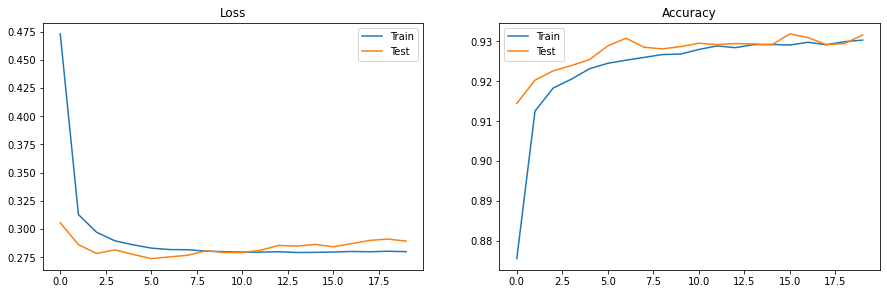

In [36]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici on observe un bon entrainement sur les données. Ici le classifieur est entrainé sur 6000 données où 1200 sevent de cross validation. Il est tout de même testé à chaque tour sur 1000 données séparées. Malgrès que le jeu de données ne soit pas équivalent à celui précédent (5000<6000), le score est si différent que de modifier cela ne ferait pas de différence. 

La fonction de perte commence à augmenter à partir de 10 epochs, cela nous renseigne sur le moment où nous aurions pu arrêter l'entrainement. 

---

**Exercice 6.** Mettre en oeuvre en Keras le réseau de neurones convolutionnel inspiré de LeNet-5 dont les couches sont décrites dans le tableau ci-dessous:

| Type | Cartes | Noyau | Pas | Activation |
|------|--------|-------|-----|-------|
| Conv.| 6      | 5x5   | 1   | tanh  |
| Av. Pooling | 6 | 2x2 | 2 | - | 
|Conv. | 12 | 5x5 | 1 | tanh |
| Av. Pooling | 12 | 2x2 | 4 | - | 
| Dense | - | 10 | - | softmax|

1. Indiquer la dimension des images et le nombre de paramètres à chaque couche. Comparer avec le modèle dense de la régression multinomiale.

2. Appliquer le modèle aux données MNIST. Comparer les résultats avec ceux de la régression multinomiale.

3. Visualiser les noyaux de convolution et apporter quelques éléments d'interprétation.

4. Faire l'apprentissage du réseau sur 6000 exemples. Comparer ses performances avec le réseau dense appris dans les mêmes conditions. Discuter.



### Vecteur

In [37]:
keras.backend.clear_session()

In [38]:
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 784, 1)
60000 train samples
10000 test samples


In [39]:
iteration = 20
input_shape = (784, 1)
num_classes = 10

In [40]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [41]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        keras.layers.Conv1D(filters=6, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=2),
        keras.layers.Conv1D(filters=12, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=4),
        keras.layers.Flatten(),
        keras.layers.Dense(units=num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 780, 6)            36        
_________________________________________________________________
average_pooling1d (AveragePo (None, 389, 6)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 385, 12)           372       
_________________________________________________________________
average_pooling1d_1 (Average (None, 96, 12)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                11530     
Total params: 11,938
Trainable params: 11,938
Non-trainable params: 0
____________________________________________________

In [42]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.6417 - accuracy: 0.8218 - val_loss: 0.2543 - val_accuracy: 0.9243
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2566 - accuracy: 0.9217 - val_loss: 0.2075 - val_accuracy: 0.9398
Epoch 3/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2102 - accuracy: 0.9368 - val_loss: 0.2072 - val_accuracy: 0.9360
Epoch 4/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1884 - accuracy: 0.9441 - val_loss: 0.1824 - val_accuracy: 0.9444
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1646 - accuracy: 0.9504 - val_loss: 0.1748 - val_accuracy: 0.9484
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1557 - accuracy: 0.9536 - val_loss: 0.1494 - val_accuracy: 0.9567
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1493 - accuracy: 0.9550 - val_loss: 0.1528 - val_accuracy

In [43]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.12087928503751755
Test accuracy: 0.9635000228881836


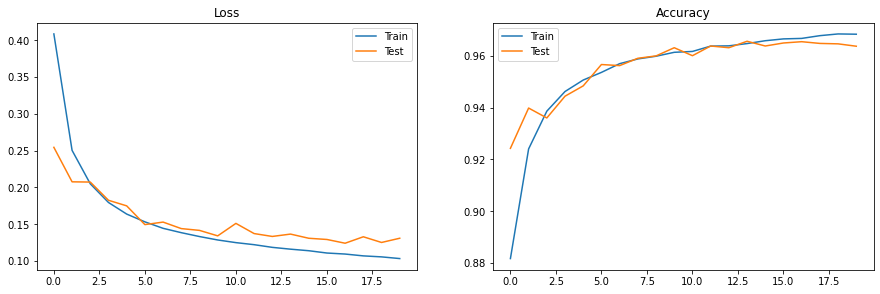

In [44]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici le modèle en 1D est assez efficace mais les courbes varient ce qui évoque une instabilité de l'apprentissage. En effet, les images étant en 2D, l'apprentissage en 1D n'est pas naturelle. L'information spatiale est perdue. 

---

### Matrice

In [45]:
keras.backend.clear_session()

In [46]:
X0 = X0.reshape(60000, 28, 28)
X1 = X1.reshape(10000, 28, 28)
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [47]:
iteration = 20
num_classes = 10

In [48]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [49]:
input_shape = (28, 28,1)
num_classes = 10

In [50]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(2*2, strides=2),
        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 12)          1812      
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1090      
Total params: 3,058
Trainable params: 3,058
Non-trainable params: 0
______________________________________________________

In [51]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.8304 - accuracy: 0.7688 - val_loss: 0.2220 - val_accuracy: 0.9352
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1961 - accuracy: 0.9444 - val_loss: 0.1344 - val_accuracy: 0.9618
Epoch 3/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1259 - accuracy: 0.9625 - val_loss: 0.1035 - val_accuracy: 0.9689
Epoch 4/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1005 - accuracy: 0.9694 - val_loss: 0.0895 - val_accuracy: 0.9739
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0870 - accuracy: 0.9734 - val_loss: 0.0837 - val_accuracy: 0.9753
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0810 - accuracy: 0.9763 - val_loss: 0.0815 - val_accuracy: 0.9765
Epoch 7/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0735 - accuracy: 0.9779 - val_loss: 0.0730 - val_accuracy

In [52]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04292500764131546
Test accuracy: 0.9848999977111816


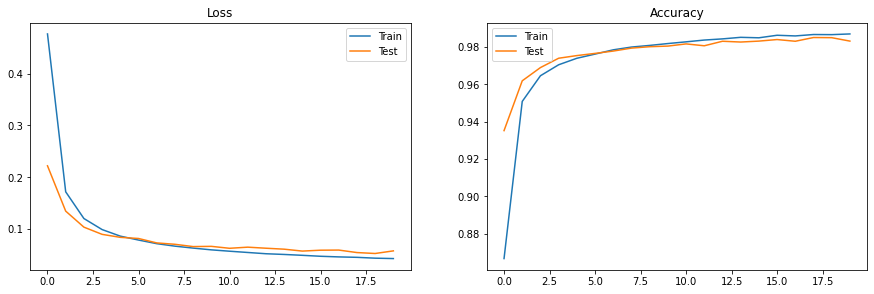

In [53]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Nous pouvons observer que les résultats du mdèles en 2D est meilleur qu'en une seule dimension. Nous puvons aussi voir que l'entrainement pourrait s'arreter au bout de 5 epochs. 

---

### Visualisation des couches 

In [54]:
keras.backend.clear_session()

In [55]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D(2*2, strides=2))
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(num_classes, activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 12)          1812      
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1090      
Total params: 3,058
Trainable params: 3,058
Non-trainable params: 0
______________________________________________________

In [56]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.8314 - accuracy: 0.7759 - val_loss: 0.2434 - val_accuracy: 0.9302
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2237 - accuracy: 0.9357 - val_loss: 0.1446 - val_accuracy: 0.9592
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1403 - accuracy: 0.9604 - val_loss: 0.1069 - val_accuracy: 0.9703
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1048 - accuracy: 0.9692 - val_loss: 0.0889 - val_accuracy: 0.9742
Epoch 5/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0849 - accuracy: 0.9752 - val_loss: 0.0816 - val_accuracy: 0.9758
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0797 - accuracy: 0.9757 - val_loss: 0.0791 - val_accuracy: 0.9773
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0692 - accuracy: 0.9783 - val_loss: 0.0691 - val_accuracy

In [57]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04026014730334282
Test accuracy: 0.9876999855041504


In [58]:
img_tensor = X1[1].reshape(28, 28)
print(img_tensor.shape)
img_tensor = image.img_to_array(img_tensor)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
#plt.imshow(img_tensor)
#plt.show()
print(img_tensor.shape)

(28, 28)
(28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [59]:
layer_outputs = [layer.output for layer in model.layers[:7]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [60]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

**Image d'entrée**

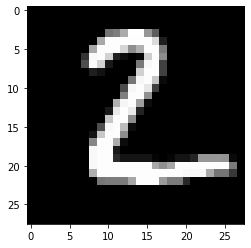

In [61]:
plt.imshow(X1[1, :].reshape(28, 28), cmap="gray")
plt.show()

**1ere couche de convolution** 

In [62]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 24, 24, 6)


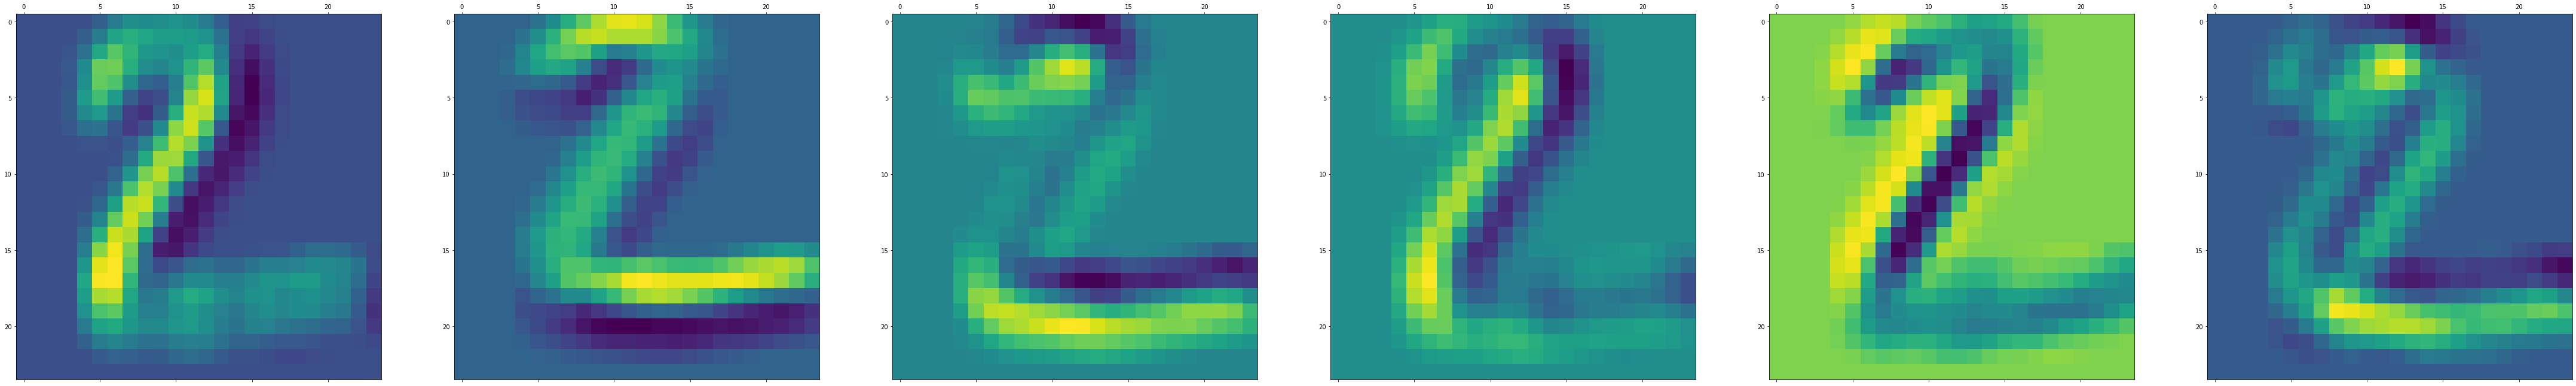

In [63]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Ici nous pouvons observer le filtrage oppéré sur les images à la première couche de convltion. Certaines images recrééent soulignent l'importance apportée à la direction des trais (1,2,6 ièmes images) ou le contraste (5ième image). 

---

**2eme couche**

In [64]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 11, 11, 6)


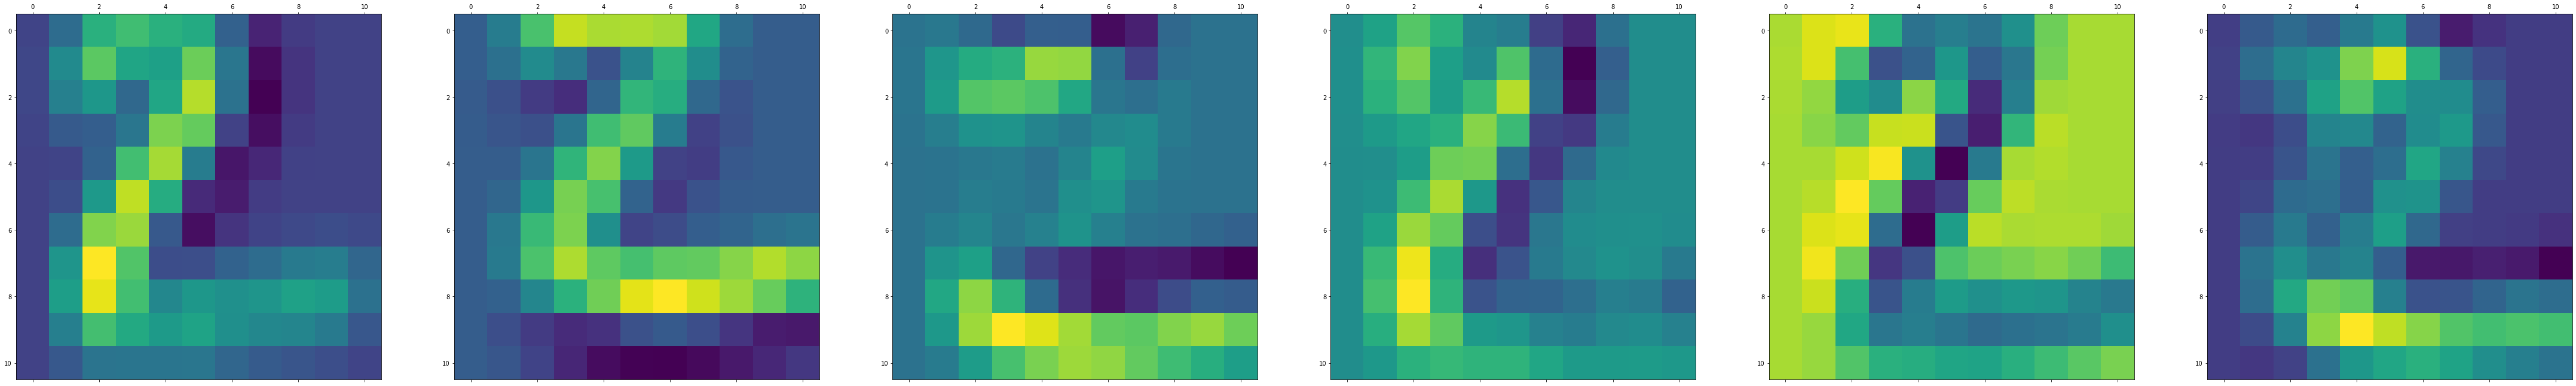

In [65]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
La seconde couche correspond à la réduction de l'image par moyenne. Ainsi les mêmes informations que la première couche sont représentés mais en condensées.

---

**3eme couche**

In [66]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 7, 7, 12)


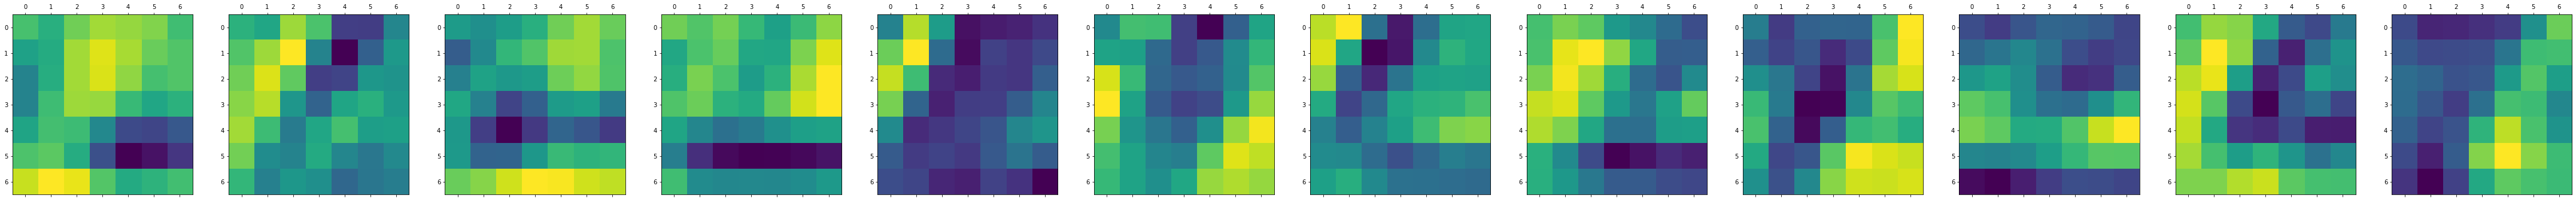

In [67]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Cette seconde couche de convolution est plus abstraite et il est difficile d'en donner une interprétation. 

---

**4eme couche**

In [68]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 3, 3, 12)


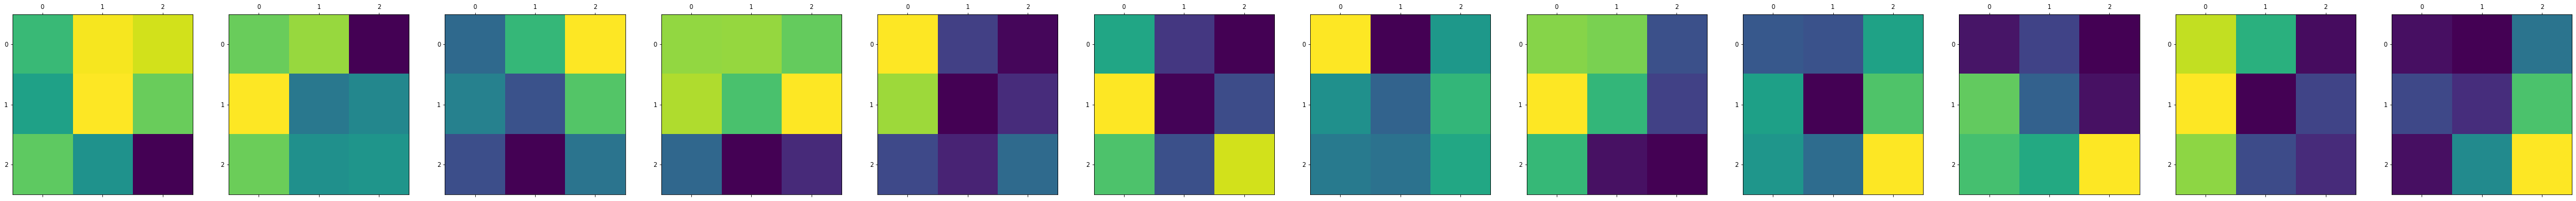

In [69]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

---
Nous avons ainsi pu voir les images reconstituées à chaque couche et ainsi voir ce qui permet au modèle de reconaitre les chiffres. Pour mieux comprendre il faudrait comparer ces différentes couches avec différents chiffres. 

---

Il existe un site internet permetant de visualiser un réseau de neurone entrainé sur les données MNIST, voici le lien : https://www.cs.ryerson.ca/~aharley/vis/conv/